## Dropout and Monte Carlo (MC) Dropout

**Dropout** is a regularization technique used to prevent overfitting in neural networks. During training, a random subset of neurons is "dropped" (i.e., temporarily ignored) in each forward pass, which forces the network to learn redundant representations.

Formally, for a layer output $\mathbf{h}$, dropout applies a binary mask $\mathbf{z} \sim \text{Bernoulli}(p)$:

$$
\tilde{\mathbf{h}} = \mathbf{z} \odot \mathbf{h}, \quad \text{where} \quad z_i \sim \text{Bernoulli}(p)
$$

This is done only during training in standard dropout.


### Monte Carlo Dropout (MC Dropout)

**MC Dropout** extends dropout to test time, allowing us to perform approximate **Bayesian inference**. By applying dropout during inference and running multiple stochastic forward passes, we obtain a distribution over predictions:

$$
p(y|\mathbf{x}, \mathcal{D}) \approx \frac{1}{T} \sum_{t=1}^{T} f^{(t)}(\mathbf{x})
$$

- Each $f^{(t)}(\mathbf{x})$ is a prediction from a randomly dropped version of the network.
- The **mean** gives the prediction.
- The **variance** gives the **model uncertainty** (epistemic uncertainty).

This technique approximates a **Bayesian Neural Network** using variational inference.


### Standard vs Bayesian Neural Network

<img src="BNN.png" width="700"/>

- In a **standard NN**, weights are fixed scalars after training.
- In a **Bayesian NN**, each weight is a distribution, capturing uncertainty.

##  Dataset: Particle Identification (PID) from Detector Responses

📌 **Source**: [Kaggle - Particle Identification](https://www.kaggle.com/datasets/naharrison/particle-identification-from-detector-responses)

This dataset simulates particle interactions with a high-energy physics detector and records responses of the detector to different particle types.

- **File**: `pid-5M.csv` (5 million samples)
- **Task**: Classify particles into types based on detector signals.
- **Target variable**: `pid` (Particle ID)
    - `0`: $\gamma$
    - `1`: $e^-$
    - `2`: $\mu^-$
    - `3`: $\pi^-$
    - `4`: $K^-$
    - `5`: $p$
    - `6`: $n$
    - `7`: $K^0$
    - `8`: $\pi^0$

- **Features**: 50 columns, mostly from calorimeter responses and other sensor readings (e.g., `s1`, `s2`, ..., `s50`).
- **Use Case**: Perfect testbed for uncertainty-aware classifiers like MC Dropout, especially for anomaly detection or ambiguous particle regions.

In this notebook, we'll:
1. Load and explore the PID dataset.
2. Train a simple MLP with dropout layers.
3. Apply MC Dropout at inference time to estimate uncertainty.
4. Visualize predictive variance across particles.


In [4]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

# Load the dataset
df = pd.read_csv("pid-5M.csv")  # adjust path as needed

# Encode the target labels (pid) into class indices
label_encoder = LabelEncoder()
df['pid_class'] = label_encoder.fit_transform(df['id'])

# Save mappings
pid_to_class = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
class_to_pid = {v: k for k, v in pid_to_class.items()}

# Feature matrix and target
X = df.drop(columns=['id', 'pid_class']).values.astype('float32')
y = df['pid_class'].values.astype('int64')

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train)
X_test_tensor = torch.tensor(X_test)
y_train_tensor = torch.tensor(y_train)
y_test_tensor = torch.tensor(y_test)

# DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=512)

# Save mappings for later
print("Class mapping (pid → class index):", pid_to_class)

Class mapping (pid → class index): {-11: 0, 211: 1, 321: 2, 2212: 3}


## MLP with MC Dropout

In [5]:
class MCDropoutMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, p=0.5):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.dropout1 = nn.Dropout(p)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.dropout2 = nn.Dropout(p)
        self.out = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        return self.out(x)

### Training

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from torchmetrics.classification import MulticlassAccuracy
from torch.nn.functional import cross_entropy

# Set fixed parameters
input_dim = X_train.shape[1]
hidden_dim = 128
output_dim = len(np.unique(y))
dropout_p = 0.3
num_epochs = 10
learning_rate = 1e-3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model
model = MCDropoutMLP(input_dim, hidden_dim, output_dim, dropout_p).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Metrics
train_acc_metric = MulticlassAccuracy(num_classes=output_dim).to(device)
test_acc_metric = MulticlassAccuracy(num_classes=output_dim).to(device)

train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

# Training loop
for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0
    train_acc_metric.reset()

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = cross_entropy(preds, yb)
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item() * xb.size(0)
        train_acc_metric.update(preds, yb)

    train_loss = epoch_train_loss / len(train_loader.dataset)
    train_acc = train_acc_metric.compute().item()
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    model.eval()
    epoch_test_loss = 0
    test_acc_metric.reset()

    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = cross_entropy(preds, yb)
            epoch_test_loss += loss.item() * xb.size(0)
            test_acc_metric.update(preds, yb)

    test_loss = epoch_test_loss / len(test_loader.dataset)
    test_acc = test_acc_metric.compute().item()
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    # Progress print
    print(f"Epoch [{epoch + 1}/{num_epochs}]")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Test  Loss: {test_loss:.4f} | Test  Acc: {test_acc:.4f}\n")

Epoch [1/10]
  Train Loss: 0.1606 | Train Acc: 0.6242
  Test  Loss: 0.0954 | Test  Acc: 0.7485

Epoch [2/10]
  Train Loss: 0.1065 | Train Acc: 0.7312
  Test  Loss: 0.0903 | Test  Acc: 0.7824

Epoch [3/10]
  Train Loss: 0.1030 | Train Acc: 0.7437
  Test  Loss: 0.0885 | Test  Acc: 0.7618

Epoch [4/10]
  Train Loss: 0.1018 | Train Acc: 0.7459
  Test  Loss: 0.0886 | Test  Acc: 0.7675

Epoch [5/10]
  Train Loss: 0.1010 | Train Acc: 0.7486
  Test  Loss: 0.0876 | Test  Acc: 0.7697

Epoch [6/10]
  Train Loss: 0.1005 | Train Acc: 0.7508
  Test  Loss: 0.0887 | Test  Acc: 0.7639

Epoch [7/10]
  Train Loss: 0.1001 | Train Acc: 0.7508
  Test  Loss: 0.1050 | Test  Acc: 0.7596

Epoch [8/10]
  Train Loss: 0.1000 | Train Acc: 0.7516
  Test  Loss: 0.0926 | Test  Acc: 0.7368

Epoch [9/10]
  Train Loss: 0.0993 | Train Acc: 0.7515
  Test  Loss: 0.0850 | Test  Acc: 0.7737

Epoch [10/10]
  Train Loss: 0.0992 | Train Acc: 0.7516
  Test  Loss: 0.0898 | Test  Acc: 0.7675



In [8]:
# save the model
torch.save(model, "mc_dropout_mlp_full.pt")

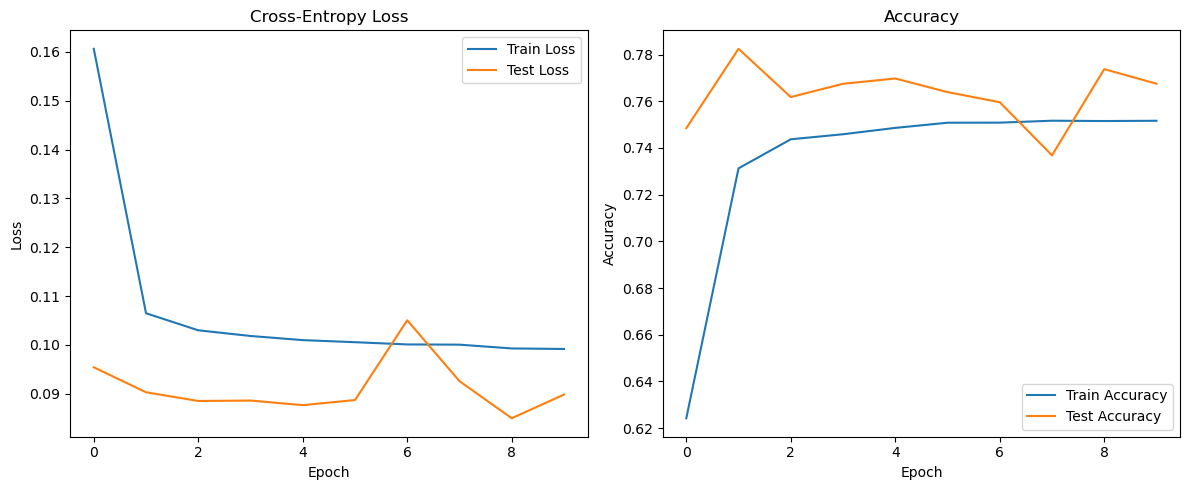

In [9]:
# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(train_losses, label='Train Loss')
ax1.plot(test_losses, label='Test Loss')
ax1.set_title("Cross-Entropy Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()

ax2.plot(train_accuracies, label='Train Accuracy')
ax2.plot(test_accuracies, label='Test Accuracy')
ax2.set_title("Accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.legend()

plt.tight_layout()
plt.show()

### MC Dropout Inference and Visualization

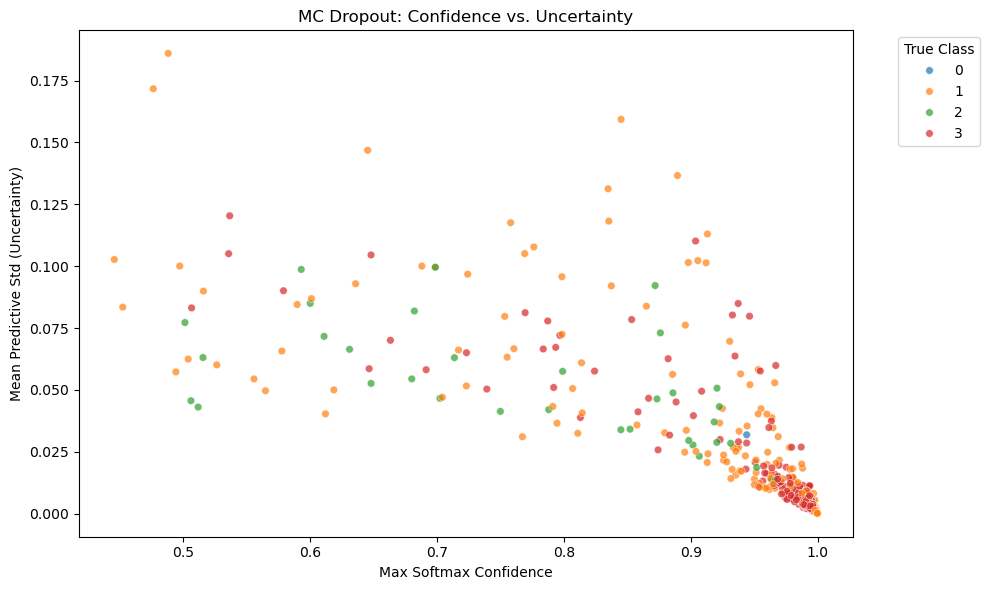

In [12]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- MC Dropout inference function ---
def mc_predict(model, x, T=30):
    model.train()  # Keep dropout active
    preds = torch.stack([torch.softmax(model(x), dim=1) for _ in range(T)])
    mean = preds.mean(dim=0)
    std = preds.std(dim=0)
    return mean, std

# --- Run on a subset of test set ---
num_samples = 1000
x_subset = X_test_tensor[:num_samples].to(device)
y_subset = y_test_tensor[:num_samples].to(device)

mean_probs, uncertainty = mc_predict(model, x_subset, T=30)
predicted_classes = mean_probs.argmax(dim=1)
confidence = mean_probs.max(dim=1).values
avg_uncertainty = uncertainty.mean(dim=1)  # average std over class probs

# --- Create DataFrame for plotting ---
results_df = pd.DataFrame({
    'true_label': y_subset.cpu().numpy(),
    'predicted': predicted_classes.cpu().numpy(),
    'confidence': confidence.detach().cpu().numpy(),
    'uncertainty': avg_uncertainty.detach().cpu().numpy()
})

# --- Plot: Confidence vs. Uncertainty ---
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=results_df,
    x="confidence",
    y="uncertainty",
    hue="true_label",
    palette="tab10",
    s=30,
    alpha=0.7
)
plt.title("MC Dropout: Confidence vs. Uncertainty")
plt.xlabel("Max Softmax Confidence")
plt.ylabel("Mean Predictive Std (Uncertainty)")
plt.legend(title="True Class", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [13]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score

# Inference with MC Dropout
def mc_predict(model, x, T=30):
    model.train()
    preds = torch.stack([torch.softmax(model(x), dim=1) for _ in range(T)])
    return preds.mean(dim=0), preds.std(dim=0)

# Subset of test data
num_samples = 5000
x_subset = X_test_tensor[:num_samples].to(device)
y_subset = y_test_tensor[:num_samples].to(device)

# Run MC prediction
mean_probs, _ = mc_predict(model, x_subset, T=30)
predicted = mean_probs.argmax(dim=1).cpu().numpy()
true = y_subset.cpu().numpy()

# Compute per-class accuracy and standard error
results = []
for cls in np.unique(true):
    mask = (true == cls)
    n = mask.sum()
    acc = accuracy_score(true[mask], predicted[mask])
    stderr = np.sqrt(acc * (1 - acc) / n) if n > 0 else 0.0
    results.append({
        "Class": cls,
        "Accuracy": acc,
        "StdError": stderr,
        "N_samples": n
    })

# Create and display table
acc_df = pd.DataFrame(results)
print(acc_df)

   Class  Accuracy  StdError  N_samples
0      0  0.142857  0.093522         14
1      1  0.977048  0.002814       2832
2      2  0.671429  0.032412        210
3      3  0.994342  0.001701       1944
